# Advanced Lane Finding Project

The steps of this project are the following:

* 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* 2. Apply a distortion correction to raw images.
* 3. Use color transforms, gradients, etc., to create a thresholded binary image.
* 4. Apply a perspective transform to rectify binary image ("birds-eye view").
* 5. Detect lane pixels and fit to find the lane boundary.
* 6. Determine the curvature of the lane and vehicle position with respect to center.
    * Warp the detected lane boundaries back onto the original image.
    * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* 7. put all functions together as a whole for video process

---
## 1st. compute the camera calibration using chessboard images

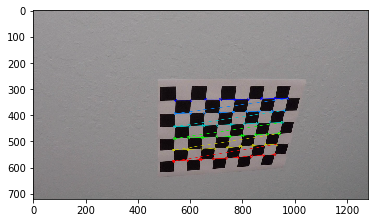

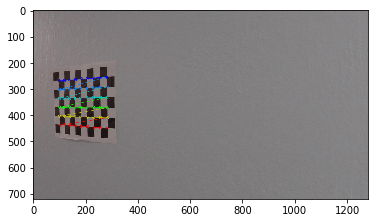

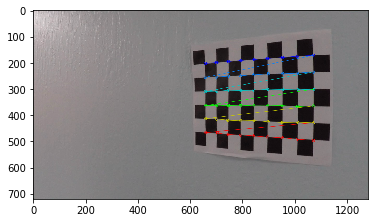

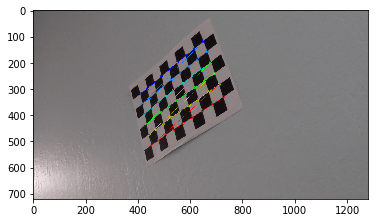

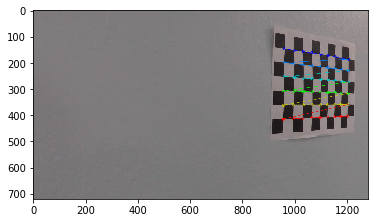

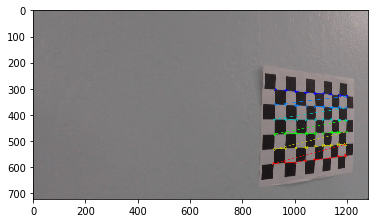

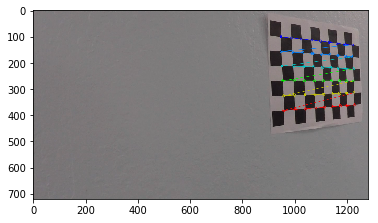

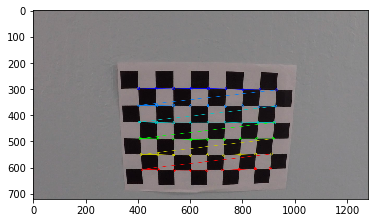

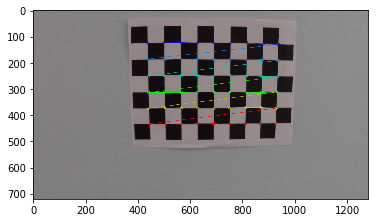

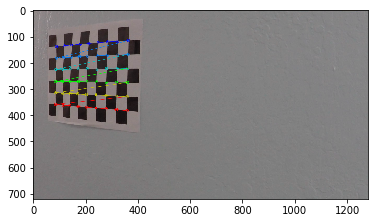

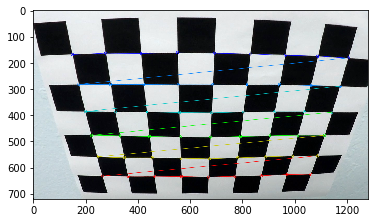

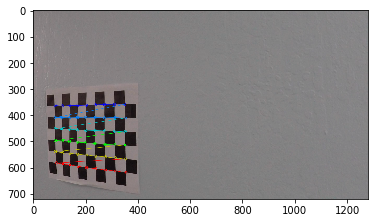

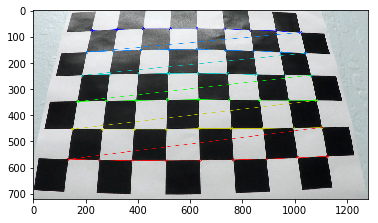

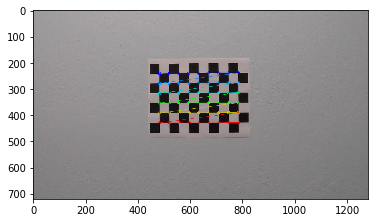

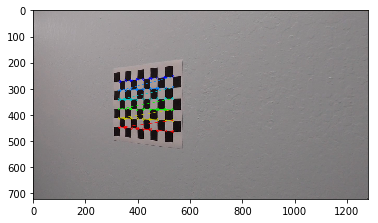

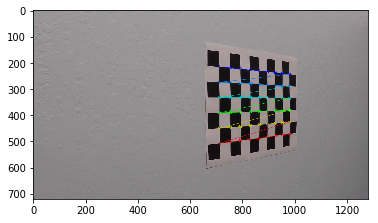

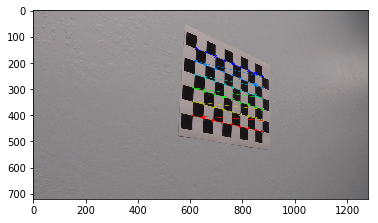

In [2]:
import numpy as np
import glob
import cv2 as cv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (9,6), corners, ret)
        fig = plt.figure()
        plt.imshow(img)


---
## 2nd. Apply a distortion correction to raw images
* use objpoints and imgpoints caculated in above cell
* skip calibrateCamera calculation once the data is ready to improve perfomace

In [3]:
def undistortImg(objpts,imgpts,distotedImage,cameraMatrix=None,distCoe=None):
    if (cameraMatrix==None) or (distCoe==None):
        imgSize = (distotedImage.shape[1],distotedImage.shape[0])
        ret_val, cameraMatrix, distCoe, r_vecs, t_vecs = cv.calibrateCamera(objpts,imgpts,imgSize,None,None)
    undistImage = cv.undistort(distotedImage,cameraMatrix,distCoe,None,cameraMatrix)
    return undistImage, cameraMatrix, distCoe

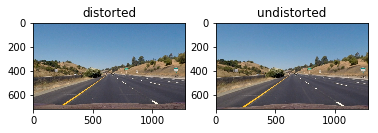

In [40]:
# Test the Function
distotedImage = mpimg.imread('test_images/straight_lines1.jpg')
fig = plt.figure()
subfig1 = fig.add_subplot(1,2,1)
plt.imshow(distotedImage)
subfig1.set_title('distorted')
undistImage, cameraMatrix, distCoe = undistortImg(objpoints,imgpoints,distotedImage)
subfig2 = fig.add_subplot(1,2,2)
plt.imshow(undistImage)
subfig2.set_title('undistorted')

---
## 3rd.  Create a thresholded binary image
* use sobel operator to creat a horizonal direction binary image
* use magnitude threshold filter to creat a binary image
* use gradient direction threshold filter to creat binary image
* use channel S of color space HLS to filter to get a binary image

In [8]:
# use sobel operator to creat a horizonal direction binary image
def sobel_x_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Take only Sobel x
    sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    #Calculate the absolute value of the x derivative:
    abs_sobelx = np.absolute(sobelx)
    #Convert the absolute value image to 8-bit:
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #Create binary image using thresholding
    sobel_x_binary = np.zeros_like(scaled_sobel)
    sobel_x_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_x_binary

# use magnitude threshold filter to creat a binary image
def magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# use gradient direction threshold filter to creat binary image
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# use channel S of color space HLS to filter to get a binary image
def hls_select(img, thresh=(0, 255)):
    hls = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

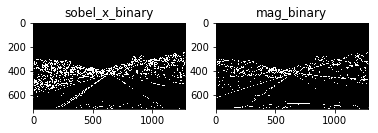

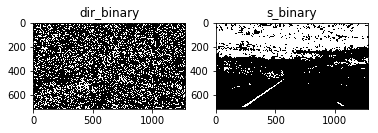

In [41]:
# test above functions
sobel_x_binary = sobel_x_threshold(undistImage, sobel_kernel=3, thresh=(10, 100))
mag_binary = magnitude_threshold(undistImage, sobel_kernel=3, thresh=(30, 100))
dir_binary = dir_threshold(undistImage, sobel_kernel=15, thresh=(1, 1.3))
s_binary = hls_select(undistImage, thresh=(100, 255))

fig1 = plt.figure()
subfig1 = fig1.add_subplot(1,2,1)
plt.imshow(sobel_x_binary,cmap = 'Greys_r')
subfig1.set_title('sobel_x_binary')
subfig2 = fig1.add_subplot(1,2,2)
plt.imshow(mag_binary,cmap = 'Greys_r')
subfig2.set_title('mag_binary')

fig2 = plt.figure()
subfig2_1 = fig2.add_subplot(1,2,1)
plt.imshow(dir_binary,cmap = 'Greys_r')
subfig2_1.set_title('dir_binary')
subfig2_2 = fig2.add_subplot(1,2,2)
plt.imshow(s_binary,cmap = 'Greys_r')
subfig2_2.set_title('s_binary')

---
## 4th. Apply a perspective transform to rectify binary image ("birds-eye view")
* wrap image
* combine threshold and wrap functions as a whole

In [72]:
# wrap image
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[800, 510], [1150, 700], [270, 700], [510, 510]])
    dst = np.float32([[650, 470], [640, 700], [270, 700], [270, 510]])
    M = cv.getPerspectiveTransform(src, dst)
    # inverse
    Minv = cv.getPerspectiveTransform(dst, src)
    # create a warped image
    warped = cv.warpPerspective(img, M, img_size, flags=cv.INTER_LINEAR)
    unpersp = cv.warpPerspective(warped, Minv, img_size, flags=cv.INTER_LINEAR)
    return warped, unpersp, Minv

# combine threshold and wrap functions as a whole
def threshold_and_wrap(image):
    # Undistort image
    cameraMatrix = None
    distCoe = None
    undist = None
    if (distCoe == None) or (cameraMatrix == None): # calculate camera calibration matrix only once
        undist, cameraMatrix,distCoe = undistortImg(objpoints,imgpoints,image)
    else:
        undist, cameraMatrix, distCoe = undistortImg(objpoints, imgpoints, image, cameraMatrix, distCoe)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    undist = cv.GaussianBlur(undist, (kernel_size, kernel_size),0)
    # Define parameters for gradient thresholding
    sobel_x_binary = sobel_x_threshold(undist, sobel_kernel=3, thresh=(22, 100))
    # mag_binary = magnitude_thresh(undist, sobel_kernel=3, thresh=(40, 100))
    # dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))

    # Define parameters for color thresholding
    s_binary = hls_select(undist, thresh=(90, 255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_x_binary)
    combined_binary[(s_binary == 1) | (sobel_x_binary == 1)] = 1
    # Apply perspective transform Define points
    warped_im, _, Minv = warp(combined_binary)
    return undist, sobel_x_binary, s_binary, combined_binary, warped_im, Minv

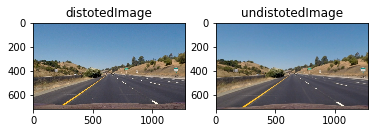

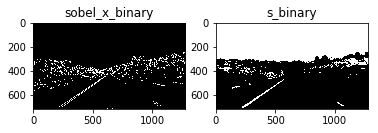

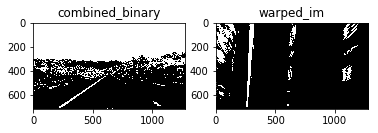

In [73]:
# test above functions
undist, sobel_x_binary, s_binary, combined_binary, warped_im, Minv = threshold_and_wrap(distotedImage)
fig3 = plt.figure()
subfig31 = fig3.add_subplot(1,2,1)
plt.imshow(distotedImage)
subfig31.set_title('distotedImage')
subfig32 = fig3.add_subplot(1,2,2)
plt.imshow(undist,cmap = 'Greys_r')
subfig32.set_title('undistotedImage')

fig4 = plt.figure()
subfig41 = fig4.add_subplot(1,2,1)
plt.imshow(sobel_x_binary,cmap = 'Greys_r')
subfig41.set_title('sobel_x_binary')
subfig42 = fig4.add_subplot(1,2,2)
plt.imshow(s_binary,cmap = 'Greys_r')
subfig42.set_title('s_binary')

fig5 = plt.figure()
subfig51 = fig5.add_subplot(1,2,1)
plt.imshow(combined_binary,cmap = 'Greys_r')
subfig51.set_title('combined_binary')
subfig52 = fig5.add_subplot(1,2,2)
plt.imshow(warped_im,cmap = 'Greys_r')
subfig52.set_title('warped_im')

---
## 5th. Detect lane pixels and fit to find the lane boundary
* firstly, use window histgram to search the lane line in a wrapped and thresholded image
* when got a efficient lane line, next frames can be detected simply

In [74]:
# use window histgram to search the lane line in a wrapped and thresholded image
def find_lane_pixels_and_fit(img):
    binary_warped = img.copy()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    idx = binary_warped.shape[0] // 2
    histogram = np.sum(binary_warped[idx:, :], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # Make this more robust
    midpoint = np.int(histogram.shape[0] // 2)  # lanes aren't always centered in the image
    leftx_base = np.argmax(histogram[150:midpoint+100]) + 150  # mask out left 150 pixels
    rightx_base = np.argmax(histogram[midpoint-100: midpoint + 400]) + midpoint-100 # mask out right

    # hyperParameter
    nwindows = 8  # Choose the number of sliding windows
    margin = 80 # Set the width of the windows +/- margin
    minpix = 70 # Set minimum number of pixels found to recenter window

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) &
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, out_img

# when got a efficient lane line, next frames can be detected simply
def fit_with_previous(left_fit, right_fit, binary_warped):
    # a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 60
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin))
                      & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new = []
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)

    if len(rightx) == 0:
        right_fit_new = []
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)

    return left_fit_new, right_fit_new

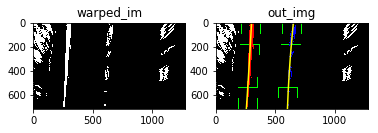

In [75]:
# Test above function
left_fit, right_fit, out_img = find_lane_pixels_and_fit(warped_im)

ploty = np.linspace(0, warped_im.shape[0] - 1, warped_im.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

fig6 = plt.figure()
subfig61 = fig6.add_subplot(1,2,1)
plt.imshow(warped_im,cmap = 'Greys_r')
subfig61.set_title('warped_im')
subfig62 = fig6.add_subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
subfig62.set_title('out_img')

---
## 6th. Determine the curvature of the lane and vehicle position with respect to center
* sannity check with left and right lines
* write text to image upper left
* calculate curvature
* draw line on image and wrap back to source image


In [76]:
# sannity check with left and right lines
def sanity_check(left_fit, right_fit):
    # Performs a sanity check on the lanes
    status = False
    # 1. Check if left and right fit returned a value
    if len(left_fit) == 0 or len(right_fit) == 0:
        return False
    # 2. Checking that they are separated by approximately the right distance horizontally
    ploty = np.linspace(0, 20, num=10)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    delta_lines = np.mean(right_fitx - left_fitx)
    if delta_lines >= 150 and delta_lines <= 430:  # delta in pixels
        status = True
    else:
        return False
    # Calculate slope
    L_0 = 2 * left_fit[0] * 360 + left_fit[1]
    R_0 = 2 * right_fit[0] * 360 + right_fit[1]
    delta_slope_mid = np.abs(L_0 - R_0)
    # 3. Checking that they are roughly parallel
    if delta_slope_mid <= 0.1:
        status = True
    else:
        return False
    return status

# write text to image upper left
def write_text_to_image(img, left_cur, right_cur, centerDelta):

    cur = (left_cur + right_cur)/2.
    font = cv.FONT_HERSHEY_TRIPLEX
    cv.putText(img, 'Radius of Curvature is %d(m)' % cur, (50, 50), font, 1.5, (0, 0, 0), 2)
    left_or_right = "left" if centerDelta < 0 else "right"
    cv.putText(img, 'Vehicle is %.1fm %s of center' % (np.abs(centerDelta), left_or_right), (50, 100), font, 1.5,(0, 0, 0), 2)

# calculat curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    # Define left and right lanes in pixels
    leftx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    rightx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    # Calculation of center
    # left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0] * y_eval) ** 2 + left_fit[0] * y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0] * y_eval) ** 2 + right_fit[0] * y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
    lane_center = (left_lane_bottom + right_lane_bottom) / 2.
    center_image = 640
    centerDelta = (lane_center - center_image) * xm_per_pix  # Convert to meters
    return left_curverad, right_curverad, centerDelta

# draw line on image and wrap back to source image
def draw_lines(undist, warped, left_fit, right_fit, left_cur, right_cur, center, Minv):

    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]))
    # Combine the result with the original image
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
    write_text_to_image(result, left_cur, right_cur, center)
    return result

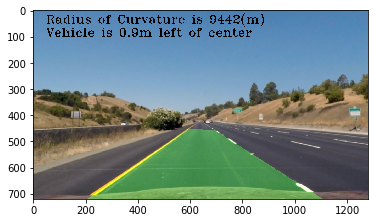

In [77]:
#test above function
left_cur, right_cur, center = curvature(left_fit, right_fit, warped_im)
result = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, Minv)
fig7 = plt.figure()
plt.imshow(result)

---
## 7. put all functions together as a whole for video process

In [79]:
IsLastFrameGood = False
# final function pipline,put above together
def process_image(image):
    global  IsLastFrameGood,last_left,last_right,left_fit,right_fit
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = threshold_and_wrap(image)
    if not IsLastFrameGood:
        left_fit, right_fit, out_img = find_lane_pixels_and_fit(warped_im)
    else:
        left_fit, right_fit = fit_with_previous(left_fit, right_fit, warped_im)
    # Do Sanity check
    status = sanity_check(left_fit, right_fit)
    # Decide if calculat new fit
    if status == True:
        last_left, last_right = left_fit, right_fit
        IsLastFrameGood = True
    else:  # Use last fit
        left_fit, right_fit = last_left, last_right
        IsLastFrameGood = False
    left_cur, right_cur, center = curvature(left_fit, right_fit, warped_im)
    result = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, Minv)

    return result

In [80]:
#test with video
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image)
processedName = "project_v_processed.mp4"
output_clip.write_videofile(processedName, audio=False)

[MoviePy] >>>> Building video project_v_processed.mp4
[MoviePy] Writing video project_v_processed.mp4


100%|█████████████████████████████████████▉| 1260/1261 [19:58<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_v_processed.mp4 



In [82]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processedName))